In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from math import sqrt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingRegressor

from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('cleaned_data.csv')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,Day,flight_time,Duration(sec)
0,Air India,01/03/2019,Banglore,New Delhi,BLR → BOM → AMD → DEL,08:50,23:55 02 Mar,39h 5m,2,No info,17135,2019,1,3,morning,140700
1,Air India,01/03/2019,Banglore,New Delhi,BLR → MAA → DEL,11:50,08:55 02 Mar,21h 5m,1,1 Long layover,14594,2019,1,3,morning,75900
2,Jet Airways,01/03/2019,Banglore,New Delhi,BLR → BOM → DEL,14:05,07:40 02 Mar,17h 35m,1,1 Long layover,22270,2019,1,3,afternoon,63300
3,Jet Airways,01/03/2019,Banglore,New Delhi,BLR → BOM → DEL,07:00,05:05 02 Mar,22h 5m,1,No info,26890,2019,1,3,morning,79500
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → DEL,18:25,21:20,2h 55m,0,No info,12649,2019,1,3,evening,10500


In [3]:
df.shape

(10462, 16)

In [4]:
df.describe()

,Total_Stops,Price,year,month,Day,Duration(sec)
count,10462.000000,10462.000000,10462.0,10462.000000,10462.000000,10462.000000
mean,0.802332,9026.790289,2019.0,5.534601,12.630090,37788.587268
std,0.660609,4624.849541,0.0,2.995344,8.791635,30040.329769
min,0.000000,1759.000000,2019.0,1.000000,3.000000,4500.000000
25%,0.000000,5224.000000,2019.0,3.000000,5.000000,10200.000000
50%,1.000000,8266.000000,2019.0,5.000000,6.000000,30300.000000
75%,1.000000,12344.750000,2019.0,6.000000,21.000000,54600.000000
max,4.000000,79512.000000,2019.0,12.000000,27.000000,171600.000000


In [5]:
df.describe(include = ['O'])

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Additional_Info,flight_time
count,10462,10462,10462,10462,10462,10462,10462,10462,10462,10462
unique,11,44,5,6,128,222,1343,368,9,4
top,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,18:55,19:00,2h 50m,No info,morning
freq,3700,490,4345,4345,2376,233,412,544,8185,4224


In [6]:
print(df['Source'].unique())
df['Destination'].unique()

['Banglore' 'Delhi' 'Chennai' 'Mumbai' 'Kolkata']


array(['New Delhi', 'Cochin', 'Kolkata', 'Hyderabad', 'Banglore', 'Delhi'],
      dtype=object)

In [7]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
year               0
month              0
Day                0
flight_time        0
Duration(sec)      0
dtype: int64

In [8]:
df.sort_values('Date_of_Journey', inplace = True)


In [9]:
df['year'] = pd.DatetimeIndex(df['Date_of_Journey']).year
df['month'] = pd.DatetimeIndex(df['Date_of_Journey']).month
df['Day'] = pd.DatetimeIndex(df['Date_of_Journey']).day

In [10]:
df['Additional_Info'].unique()


array(['No info', 'Change airports', '1 Long layover', 'Business class',
       '1 Short layover', 'Red-eye flight', '2 Long layover',
       'In-flight meal not included', 'No check-in baggage included'],
      dtype=object)

Text(0, 0.5, 'Price of ticket')

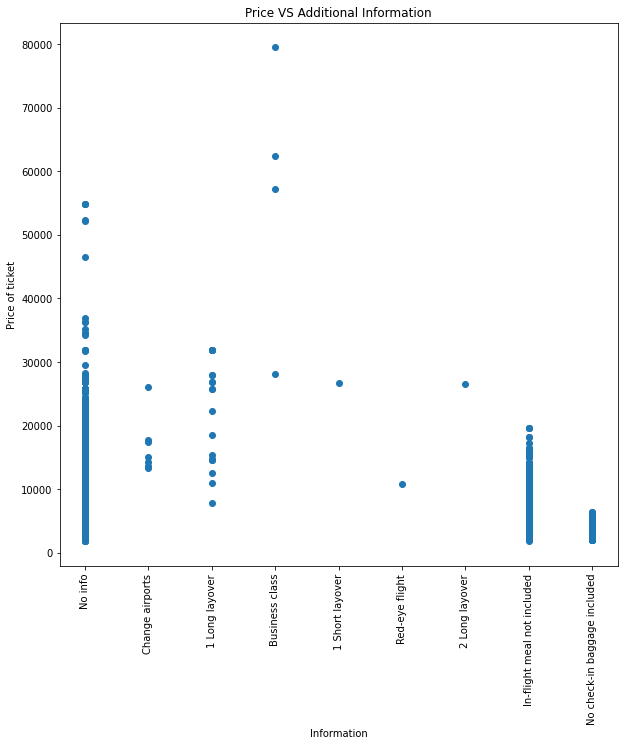

In [11]:
plt.figure(figsize = (10, 10))
plt.title('Price VS Additional Information')
plt.scatter(df['Additional_Info'], df['Price'])
plt.xticks(rotation = 90)
plt.xlabel('Information')
plt.ylabel('Price of ticket')

Text(0, 0.5, 'Count of flights')

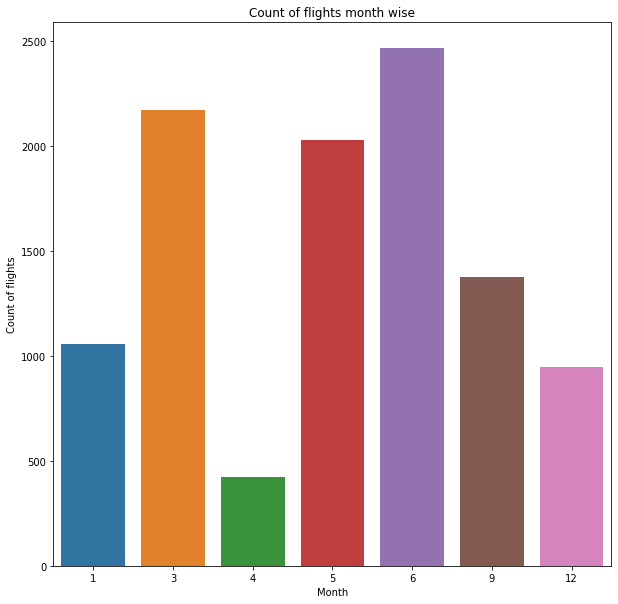

In [12]:
plt.figure(figsize = (10 , 10))
plt.title('Count of flights month wise')
sns.countplot(x = 'month', data = df)
plt.xlabel('Month')
plt.ylabel('Count of flights')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

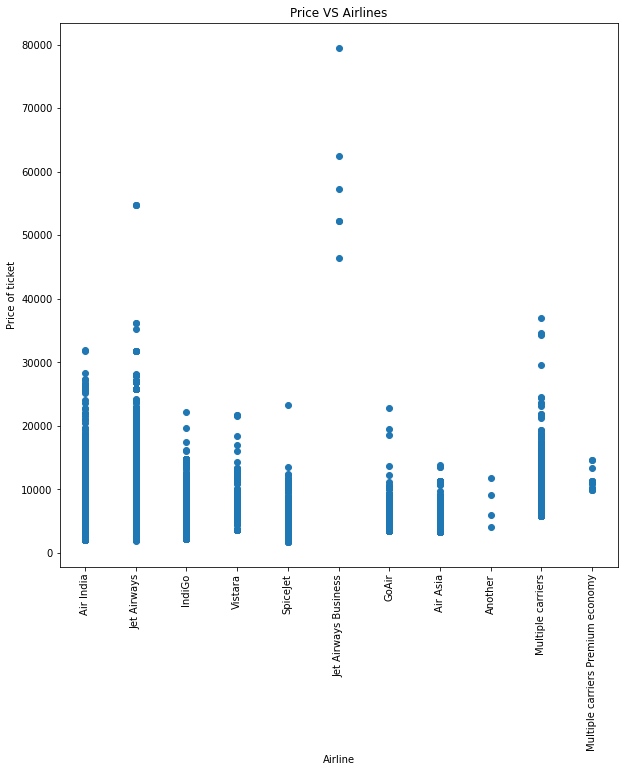

In [13]:
plt.figure(figsize = (10, 10))
plt.title('Price VS Airlines')
plt.scatter(df['Airline'], df['Price'])
plt.xticks(rotation = 90)
plt.xlabel('Airline')
plt.ylabel('Price of ticket')
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

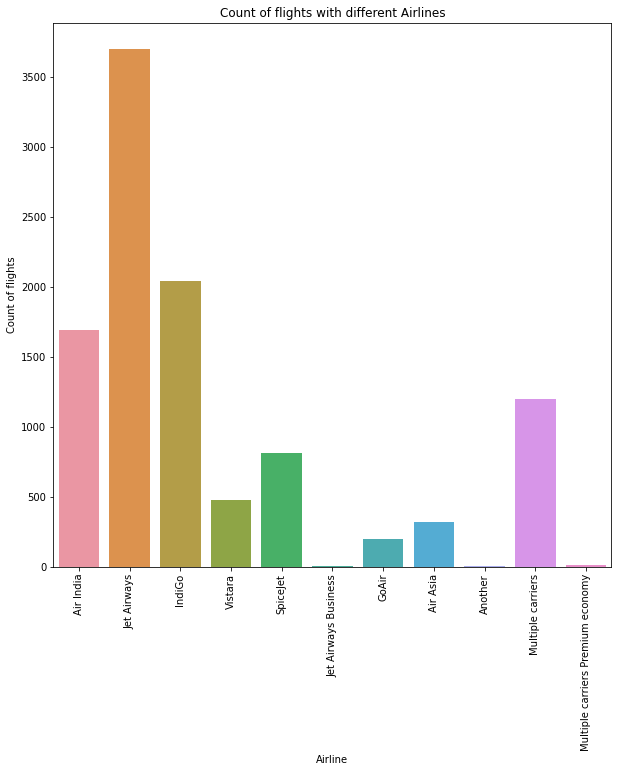

In [14]:
plt.figure(figsize = (10, 10))
plt.title('Count of flights with different Airlines')
sns.countplot(x = 'Airline', data = df)
plt.xlabel('Airline')
plt.ylabel('Count of flights')
plt.xticks(rotation = 90)

In [15]:
df['Airline'].replace(['Trujet', 'Vistara Premium economy'], 'Another', inplace = True)

In [16]:
df[df['Total_Stops'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,Day,flight_time,Duration(sec)


In [17]:
df.dropna(axis = 0, inplace = True)

In [18]:
def convert_into_stops(X):
    if X == '4 stops':
        return 4
    elif X == '3 stops':
        return 3
    elif X == '2 stops':
        return 2
    elif X == '1 stop':
        return 1
    elif X == 'non stop':
        return 0

In [19]:
df['Total_Stops'] = df['Total_Stops'].map(convert_into_stops)

In [20]:
df.fillna(0, inplace  = True)
df['Total_Stops'] = df['Total_Stops'].apply(lambda x : int(x))

In [21]:
def flight_dep_time(X):
    '''
    This function takes the flight Departure time 
    and convert into appropriate format.
    '''
    if int(X[:2]) >= 0 and int(X[:2]) < 6:
        return 'mid_night'
    elif int(X[:2]) >= 6 and int(X[:2]) < 12:
        return 'morning'
    elif int(X[:2]) >= 12 and int(X[:2]) < 18:
        return 'afternoon'
    elif int(X[:2]) >= 18 and int(X[:2]) < 24:
        return 'evening'

In [22]:
df['flight_time'] = df['Dep_Time'].apply(flight_dep_time)

Text(0, 0.5, 'Count of flights')

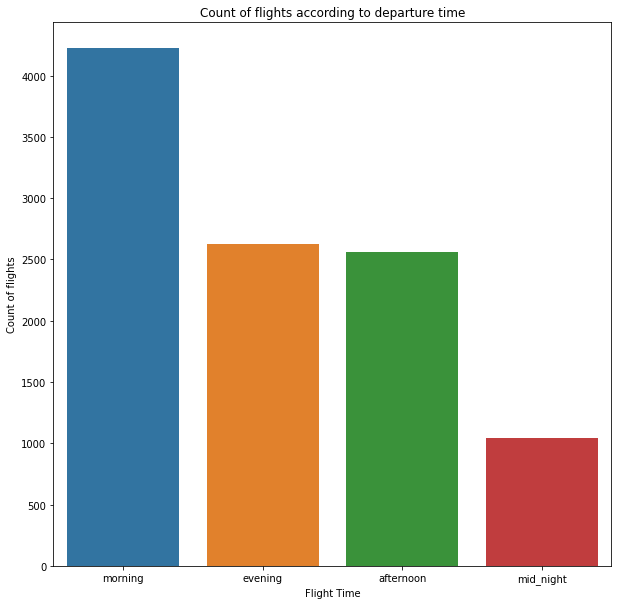

In [23]:
plt.figure(figsize = (10, 10))
plt.title('Count of flights according to departure time')
sns.countplot(x = 'flight_time', data = df)
plt.xlabel('Flight Time')
plt.ylabel('Count of flights')

In [24]:
def convert_into_seconds(X):
    '''
    This function takes the total time of flight from
    one city to another and converts it into the seconds.
    '''
    a = [int(s) for s in re.findall(r'-?\d+\.?\d*', X)]
    if len(a) == 2:
        hr = a[0] * 3600
        min = a[1] * 60
    else:
        hr = a[0] * 3600
        min = 0   
    total = hr + min
    return total

df['Duration(sec)'] = df['Duration'].map(convert_into_seconds)

Text(0, 0.5, 'Price of ticket')

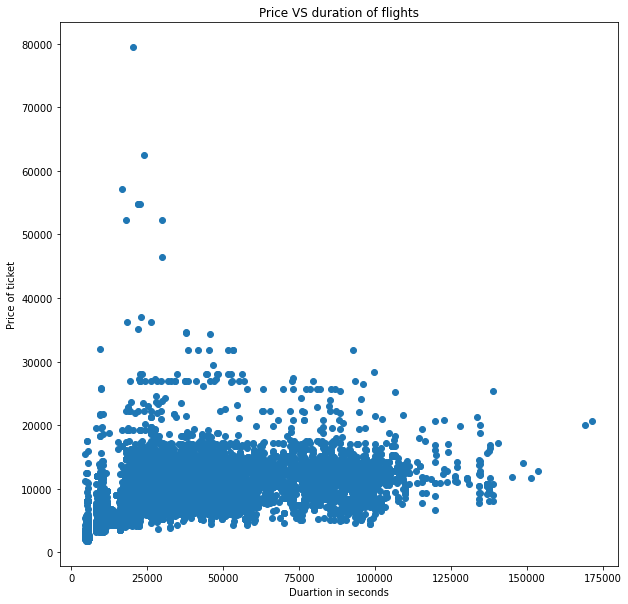

In [25]:
plt.figure(figsize = (10, 10))
plt.title('Price VS duration of flights')
plt.scatter(df['Duration(sec)'], df['Price'])
plt.xlabel('Duartion in seconds')
plt.ylabel('Price of ticket')

In [26]:
df.corr()

,Total_Stops,Price,year,month,Day,Duration(sec)
Total_Stops,NaN,NaN,NaN,NaN,NaN,NaN
Price,NaN,1.000000,NaN,0.008662,-0.171142,0.501886
year,NaN,NaN,NaN,NaN,NaN,NaN
month,NaN,0.008662,NaN,1.000000,-0.265200,0.056340
Day,NaN,-0.171142,NaN,-0.265200,1.000000,-0.047321
Duration(sec),NaN,0.501886,NaN,0.056340,-0.047321,1.000000


In [27]:
df.shape

(10462, 16)

In [28]:
df = df.drop_duplicates()
df.shape

(10462, 16)

In [29]:
df['Additional_Info'].unique()

array(['No info', 'Change airports', '1 Long layover', 'Business class',
       '1 Short layover', 'Red-eye flight', '2 Long layover',
       'In-flight meal not included', 'No check-in baggage included'],
      dtype=object)

In [30]:
df['Additional_Info'].replace('No Info', 'No info', inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


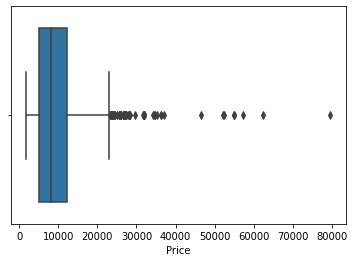

In [31]:
sns.boxplot(df['Price'])

In [32]:
df.to_csv('cleaned_data.csv', index = None)

In [33]:
df = pd.get_dummies(df, columns = ['Airline', 'Source', 'Destination', 'Additional_Info', 'flight_time'])

In [34]:
pd.set_option('display.max_columns', 50)
df.head()

,Date_of_Journey,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,year,month,Day,Duration(sec),Airline_Air Asia,Airline_Air India,Airline_Another,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Vistara,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Additional_Info_1 Long layover,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight,flight_time_afternoon,flight_time_evening,flight_time_mid_night,flight_time_morning
0,01/03/2019,BLR → BOM → AMD → DEL,08:50,23:55 02 Mar,39h 5m,0,17135,2019,1,3,140700,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
97,01/03/2019,BLR → BOM → DEL,08:55,16:10,7h 15m,0,26890,2019,1,3,26100,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
98,01/03/2019,BLR → BOM → DEL,06:45,12:15,5h 30m,0,23677,2019,1,3,19800,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
99,01/03/2019,BLR → DEL,22:20,01:10 02 Mar,2h 50m,0,11934,2019,1,3,10200,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
100,01/03/2019,BLR → VGA → VTZ → DEL,10:30,17:45,7h 15m,0,17461,2019,1,3,26100,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1


In [35]:
df.drop(['Date_of_Journey', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration'], axis = 1, inplace = True)

In [36]:
df.to_csv('final_data.csv', index = None)

In [37]:
y = df['Price']
X = df.drop('Price', axis = 1)

In [38]:
s = StandardScaler()
X = s.fit_transform(X)

In [39]:
print(X.mean())
X.std()

-7.829502461942655e-18


0.9746794344808963

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [41]:
print("The size of training input is", X_train.shape)
print("The size of training output is", y_train.shape)
print(50 *'*')
print("The size of testing input is", X_test.shape)
print("The size of testing output is", y_test.shape)

The size of training input is (8369, 40)
The size of training output is (8369,)
**************************************************
The size of testing input is (2093, 40)
The size of testing output is (2093,)


In [42]:
y_train_pred = np.ones(X_train.shape[0]) * y_train.mean()
y_test_pred = np.ones(X_test.shape[0]) * y_train.mean()

In [43]:
print("Train Results for Baseline Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Baseline Model:
--------------------------------------------------
Root mean squared error:  4687.098903098816
R-squared:  0.0


In [44]:
print("Test Results for Baseline Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Baseline Model:
--------------------------------------------------
Root mean squared error:  4366.236544127735
R-squared:  -0.0007421166562391335


In [45]:
k_range = list(range(1, 30))
params = dict(n_neighbors = k_range)
knn_regressor = GridSearchCV(KNeighborsRegressor(), params, cv = 10, scoring = 'neg_mean_squared_error')
knn_regressor.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29]},
             scoring='neg_mean_squared_error')

In [46]:
print(knn_regressor.best_estimator_)
knn_regressor.best_params_

KNeighborsRegressor(n_neighbors=4)


{'n_neighbors': 4}

In [47]:
y_train_pred =knn_regressor.predict(X_train) ##Predict train result
y_test_pred =knn_regressor.predict(X_test) ##Predict test result

In [48]:
print("Train Results for KNN Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for KNN Regressor Model:
--------------------------------------------------
Root mean squared error:  1733.6212616218863
R-squared:  0.8631955533261911


In [49]:
print("Test Results for KNN Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for KNN Regressor Model:
--------------------------------------------------
Root mean squared error:  2237.0528159393016
R-squared:  0.737299963795221


In [50]:
params ={'alpha' :[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
ridge_regressor =GridSearchCV(Ridge(), params ,cv =5,scoring = 'neg_mean_absolute_error', n_jobs =-1)
ridge_regressor.fit(X_train ,y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             scoring='neg_mean_absolute_error')

In [51]:
print(ridge_regressor.best_estimator_)
ridge_regressor.best_params_

Ridge(alpha=100)


{'alpha': 100}

In [52]:
y_train_pred =ridge_regressor.predict(X_train) ##Predict train result
y_test_pred =ridge_regressor.predict(X_test) ##Predict test result

In [53]:
print("Train Results for Ridge Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Ridge Regressor Model:
--------------------------------------------------
Root mean squared error:  2767.6755409642215
R-squared:  0.6513239511161706


In [54]:
print("Test Results for Ridge Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Ridge Regressor Model:
--------------------------------------------------
Root mean squared error:  2661.761473310326
R-squared:  0.6280830885512727
